In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output


%matplotlib inline


In [10]:
cd /Users/austinmcdonald/Desktop/catest

/Users/austinmcdonald/Desktop/Catest


In [14]:
files = os.listdir()
#files[0:10]
files = files[1:]
files = files[0:289]

In [15]:
len(files)

289

In [16]:
SpotInfo2 = []
AllPairs =[]
Shape = 201
Row = int(2) # define the area to take around the spots
Col = int(2) # define the area to take around the spots
xvs = np.arange(0,Shape)
#DataS=np.zeros(Shape**2).reshape((Shape,Shape))
neighborhood_size = 5

ct = 0
DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
for q in range(0,len(files)):
    Images = np.array(Image.open(files[q]))
    ImageB = []
    for x in range(0,Shape):
        coefs = poly.polyfit(xvs, Images[x], 11) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        hold  = Images[x]-(ffit)
        hold[hold < 0] = 0        # replaces negtive values form the sub with 0
        ImageB.append(hold)
    DataSub += ImageB 
    ct += 1
    if ct > 20:
        ct = 0
        data = DataSub
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        #threshold = 4*np.mean(data)
        threshold = 6*np.std(data)

        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        Pairs = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            x.append(x_center)
            y_center = (dy.start + dy.stop - 1)/2    
            y.append(y_center)
            Pairs.append((x_center,y_center))
        for item in Pairs:
            if item not in AllPairs:
                AllPairs.append(item) 
        
    clear_output()
    print('Finding AllPairs')
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))   
    Images = None
    ImageB = None
    data   = None
    Slices = None
    labeled= None
    num_objects=None
    
############################################################## 

Xc,Yc = zip(*AllPairs)

for q in range(0,len(files)):
    Images = np.array(Image.open(files[q]))
    ImageB = []
    for x in range(0,81):
        coefs = poly.polyfit(xvs, Images[x], 11) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        hold  = Images[x]-(ffit)
        hold[hold < 0] = 0        # replaces negtive values form the sub with 0
        ImageB.append(hold)

    ImageB = np.array(ImageB)
    SpotInfoHolder = []

    for w in range(0,len(Xc)):
        Xindex = int(Xc[w])
        Yindex = int(Yc[w])
        spot = ImageB[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1]
        ATot = spot.sum()
        SpotInfo2.append([q,Xindex,Yindex,ATot])

##############################################################  
       
    clear_output()
    print('Finding all areas') 
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))


Finding all areas
On file 289 of 289


In [17]:
len(AllPairs)

378

In [18]:
Par = len(AllPairs)
SpotArea = []
PairsMade = []
AreaCut = 4e3
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    aboveCut = len([i for i in HoldArea if i > AreaCut])
    grad = abs(np.gradient(HoldArea))
#    if aboveCut > 10 :
    if max(grad)>2e3 and aboveCut > 10:
        SpotArea.append(HoldArea)
        PairsMade.append(AllPairs[x])
len(PairsMade)

20

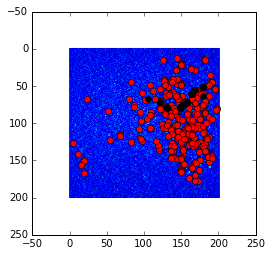

In [19]:
plt.imshow(DataSub)
a,b = zip(*AllPairs)
plt.plot(a,b, 'ro')

c,d = zip(*PairsMade)
plt.plot(c,d, 'ko')

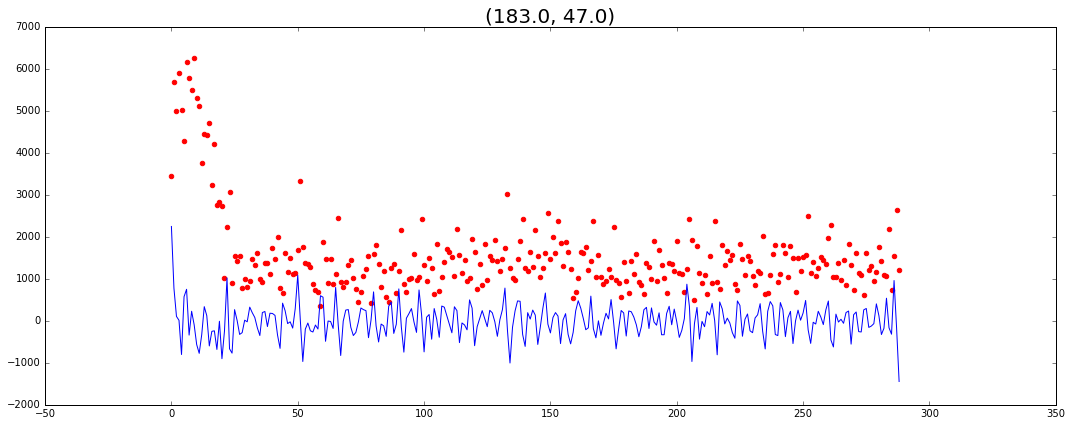

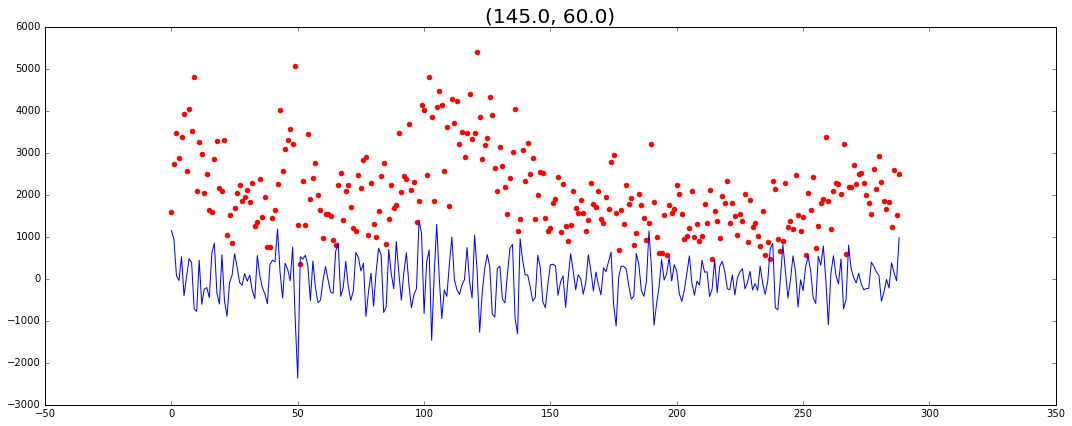

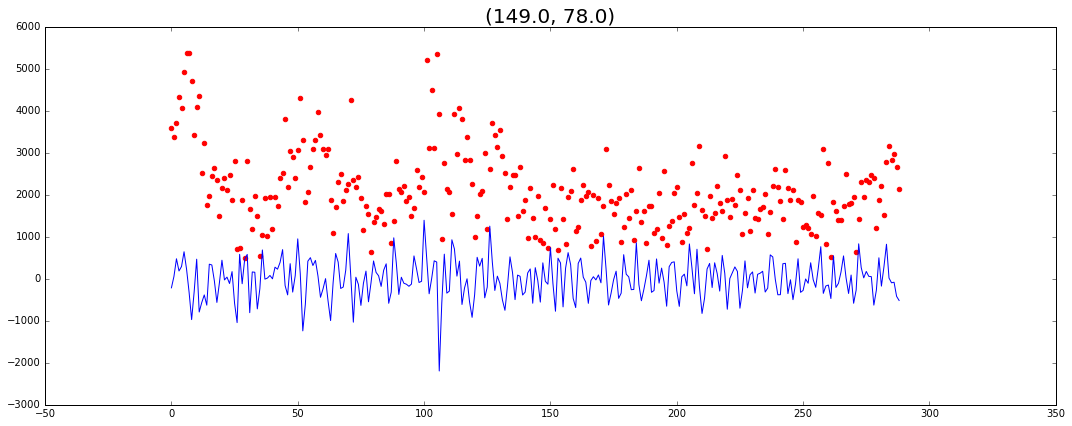

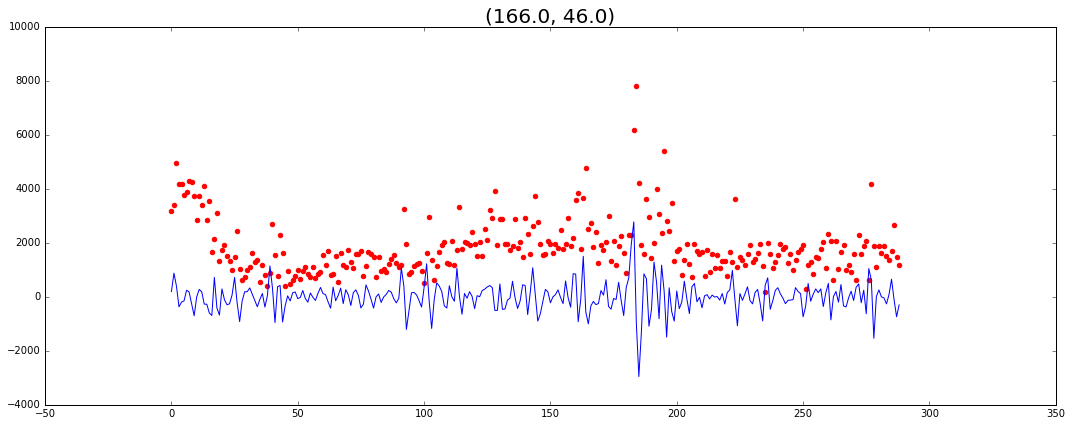

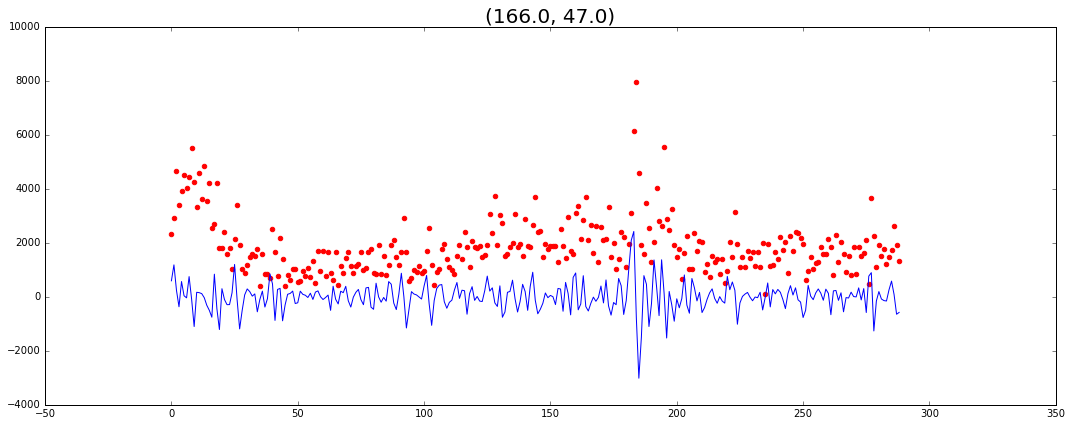

In [9]:
vals =np.arange(0,len(files))
for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    plt.scatter(vals,SpotArea[x],color='r')
    plt.plot(vals,np.gradient(SpotArea[x]))
    #plt.scatter(vals,BackG[x])
    plt.tight_layout()
    plt.show()